In [1]:
import numpy as np
from myplotstyle import plt, get_figsize

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

from astropy.table import join
from collections import defaultdict
from scipy.stats import spearmanr, norm

In [2]:
print(SAGA.__version__)
saga = SAGA.QuickStart()

3.0.0
SAGA `shared_dir` set to /home/yymao/Dropbox/Work/SAGA
SAGA `local_dir`  set to /home/yymao/Documents/Work/Data/SAGA


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())

# for this notebook
base = Query(C.sat_rcut, "p_sat_corrected > 0").filter(base)

nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

In [4]:
hosts = saga.host_catalog.load(include_stats=True, query="paper3")

hosts["nuv_ssfr"] = hosts["nuv_sfr"] - hosts["log_sm"]
hosts["qf_gold"] = hosts["sats_gold_quenched"] / hosts["sats_gold"]
hosts["qf_gold_silver"] = hosts["sats_gold_silver_quenched"] / hosts["sats_gold_silver"]

In [5]:
d = defaultdict(list)
for host in hosts["HOSTID"]:
    d["HOSTID"].append(host)

    sats_this = Query(C.is_sat, QueryMaker.equal("HOSTID", host)).filter(base)
    d["sat_gold_median_distance"].append(np.median(C.sample_gold.filter(sats_this, "RHOST_KPC")) if C.sample_gold.count(sats_this) else np.nan)

    sat_Mr = sats_this["Mr"]
    if len(sat_Mr) > 1:
        sat_Mr = np.sort(sat_Mr)
        gap = sat_Mr[1] - sat_Mr[0]
    else:
        gap = np.nan
    d["sat_gap"].append(gap)

hosts = join(hosts, d, "HOSTID")

In [6]:
def print_sci(x, n=0):
    x = float(x)
    s = (f"{{:.{n}E}}").format(x)
    a, _, b = s.partition("E")
    if abs(int(b)) <= 1:
        return (f"{{:.{n}f}}").format(x)
    b = int(b)
    return f"${a} \\times 10^{{{b}}}$"

def calc_sign(a, b):
    return np.sign(spearmanr(a, b, nan_policy="omit").statistic)

def calc_stats(a, b):
    return np.abs(spearmanr(a, b, nan_policy="omit").pvalue)

def count_valid(a, b):
    return len(a) - np.count_nonzero(np.isnan(a) | np.isnan(b))

In [7]:
print(norm.sf(2)*2, norm.sf(3)*2)

0.04550026389635839 0.0026997960632601866


In [8]:
n = 101
a = np.random.default_rng(123).random(size=n)
print(spearmanr(a, a + np.random.default_rng(123).normal(size=n)*1.01152))
print(spearmanr(a, a + np.random.default_rng(123).normal(size=n)*0.741))

SignificanceResult(statistic=0.1997320908561444, pvalue=0.04522847591162451)
SignificanceResult(statistic=0.2961793826441467, pvalue=0.0026358322677493286)


In [9]:
columns, column_labels = zip(*[
    ("K_ABS", "$M_K$"),
    ("M_HALO", "Group mass"),
    ("NEAREST_MASSIVE_DIST", "$d$ to nearest\nmassive host"),
    ("gr", "$g-r$"),
    ("ba", "$b/a$"),
    ("phi", "Position angle"),
    ("sb_r", "Surface\nBrightness"),
    ("SERSIC", "Sersic Index"),
    ("log_sm", "Stellar mass"),
    ("most_massive_sat", "Most massive sat\nstellar mass"),
    ("nuv_sfr", "NUV SFR"),
    ("nuv_ssfr", "NUV sSFR"),
    ("sat_gold_median_distance", "Median satellite\ndistance (Gold)"),
    ("sat_gap", "1st/2nd satellites\nmagnitude gap"),
    ("LOG_MHI", "HI mass"),
], strict=True)

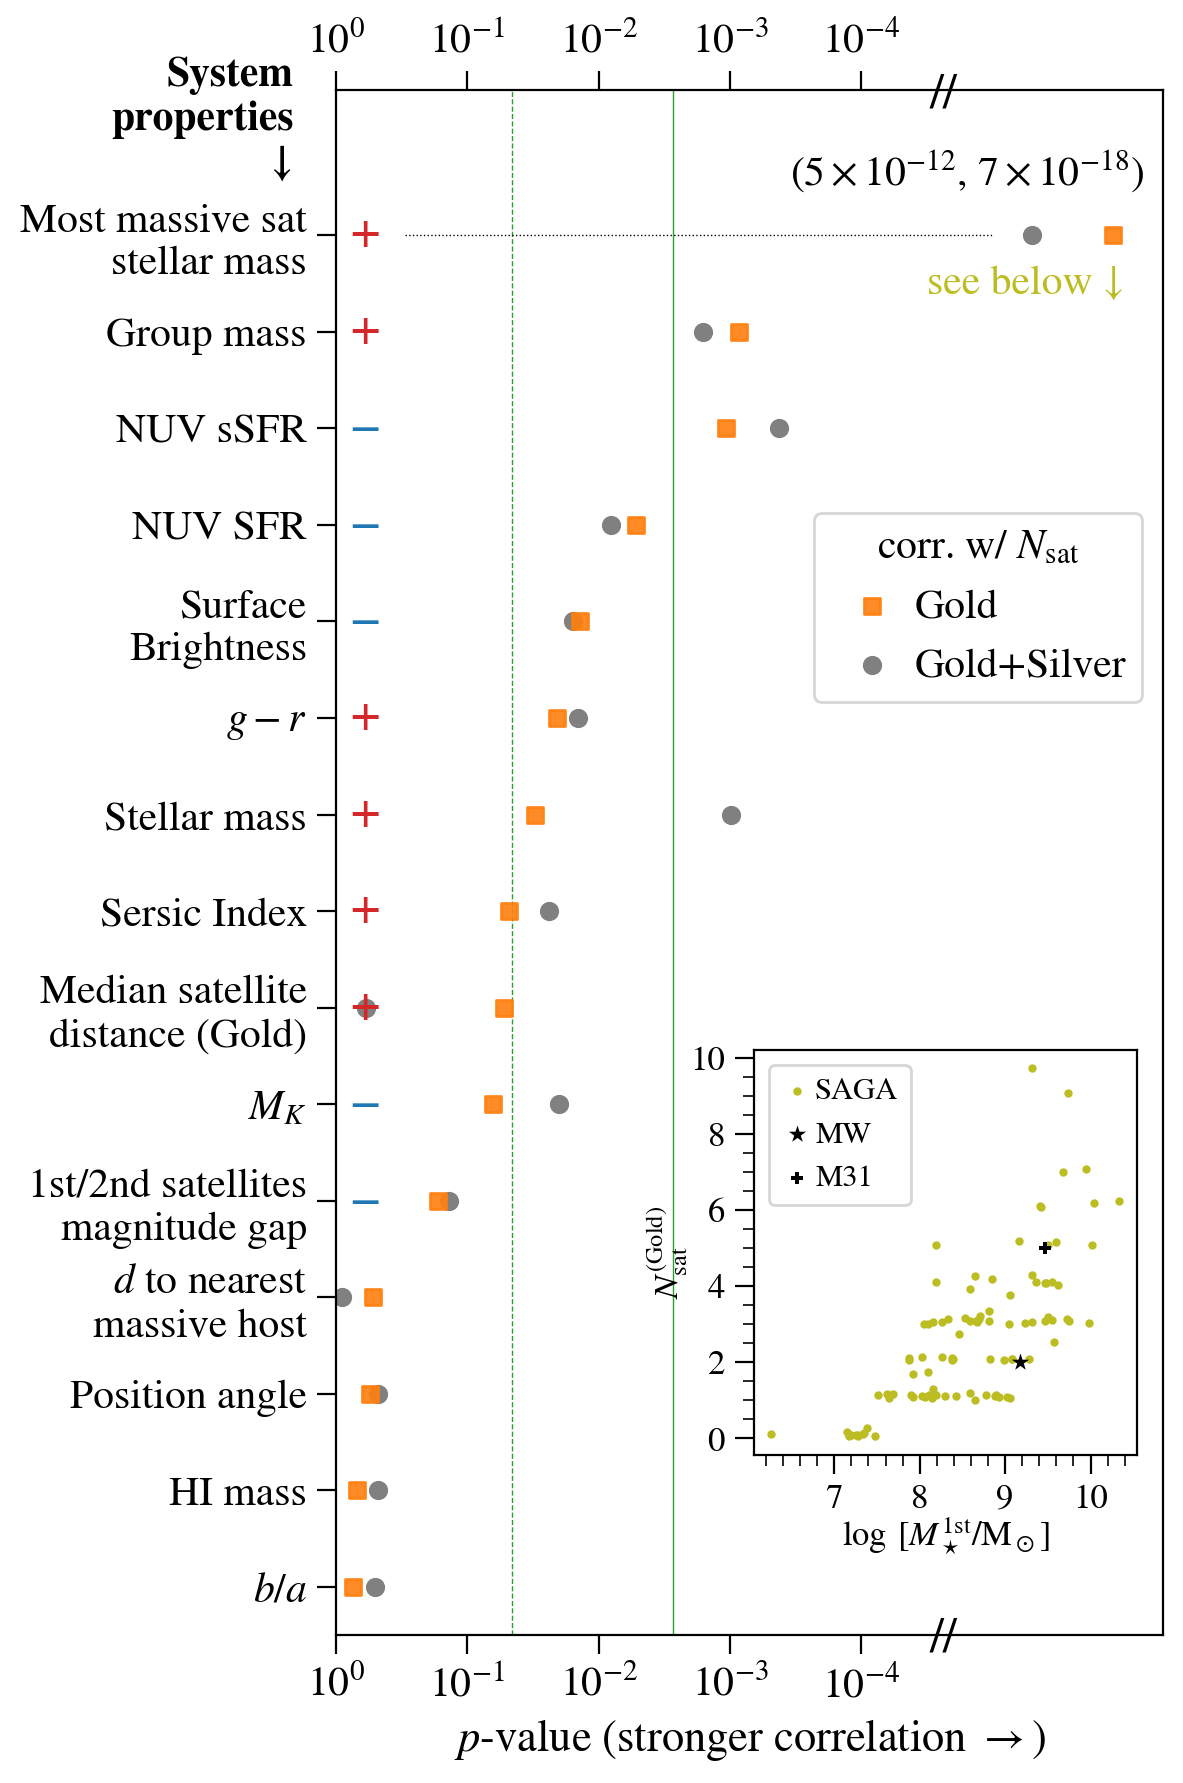

In [10]:
plot_nsats = True #and False
if plot_nsats:
    key_prefix = "sats"
    legend_title = "$N_{\\rm sat}$"
    scatter_ylabel = "$N_{\\rm sat}^{\\rm (Gold)}$"
else:
    key_prefix = "qf"
    legend_title = "Quenched Frac."
    scatter_ylabel = "Quenched Frac. (Gold)"


fig = plt.figure(figsize=get_figsize(ratio=0.65))

k1 = np.array([calc_stats(hosts[col], hosts[f"{key_prefix}_gold"]) for col in columns])
k2 = np.array([calc_stats(hosts[col], hosts[f"{key_prefix}_gold_silver"]) for col in columns])
sgn1 = np.array([calc_sign(hosts[col], hosts[f"{key_prefix}_gold"]) for col in columns])
sgn2 = np.array([calc_sign(hosts[col], hosts[f"{key_prefix}_gold_silver"]) for col in columns])
mask = (k1 < 0.2) | (k2 < 0.2)
assert (sgn1[mask] == sgn2[mask]).all()

s = np.argsort(k1)[::-1]
y = np.arange(len(columns))
plt.scatter(k1[s], y, s=35, color="C1", marker="s", label="Gold", zorder=2, alpha=0.9)
plt.scatter(k2[s], y, s=35, color="grey", label="Gold+Silver", zorder=1)

plt.axvline(norm.sf(2)*2, ls="--", color="C2", zorder=0, lw=0.5)
plt.axvline(norm.sf(3)*2, ls="-", color="C2", zorder=0, lw=0.5)

plt.legend(frameon=True, handletextpad=0.01, bbox_to_anchor=(1, 0.74), loc="upper right", title=f"corr. w/ {legend_title}")

plt.semilogx()
plt.xlim(1, 5e-7)
plt.xticks(np.logspace(-4, 0, 5))
plt.gca().tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
plt.xlabel("$p$-value (stronger correlation $\\rightarrow$)")
plt.text(3e-5, len(columns)+0.45, "//", va="center", fontsize="large")
plt.text(3e-5, -0.55, "//", va="center", fontsize="large")

plt.ylim(-0.5, len(columns)-0.5+1)
plt.gca().set_yticks(np.arange(len(columns)), [column_labels[i] for i in s])
plt.gca().tick_params(axis='y', which='minor', left=False)

plt.text(2.1, len(columns)+0.2, "System\nproperties\n↓", ha="right", va="center", fontweight="bold")

for i, idx in enumerate(s):
    sgn = sgn1[idx]
    if mask[idx]:
        plt.text(0.8, i, r"$\mathbf{+}$" if sgn > 0 else r"$\mathbf{-}$", va="center", ha="left", color=("C3" if sgn > 0 else "C0"))

plt.scatter(1.2e-6, len(columns)-1, s=35, color="C1", marker="s", label="Gold", zorder=2, alpha=0.9)
if plot_nsats:
    plt.scatter(5e-6, len(columns)-1, s=35, color="grey", label="Gold+Silver", zorder=1)
    plt.text(7e-7, len(columns)-0.35, f"({print_sci(k2[s[-1]])}, {print_sci(k1[s[-1]])})", va="center", ha="right")
    plt.plot([0.3, 1e-5], [len(columns)-1]*2, lw=0.5, ls=":", c="k")
else:
    plt.text(7e-7, len(columns)-0.35, f"({print_sci(k1[s[-1]])})", va="center", ha="right")

plt.text(1e-6, len(columns)-1.5, "see below ↓", ha="right", va="center", color="C8")

ax_inset = fig.add_axes([0.64, 0.18, 0.33, 0.23])
ax_inset.scatter(hosts["most_massive_sat"], hosts[f"{key_prefix}_gold"], s=4, color="C8", label="SAGA")
ax_inset.tick_params(labelsize="small")
ax_inset.set_xticks([7,8,9,10])
ax_inset.scatter([9.176], [2 if plot_nsats else 0], marker="*", c="k", s=42, lw=0, label="MW")
ax_inset.scatter([9.462], [5 if plot_nsats else 0.33], marker="P", c="k", s=18, lw=0, label="M31")
ax_inset.set_yticks(np.arange(0, 11, 2) if plot_nsats else np.linspace(0, 1, 6))
ax_inset.set_xlabel(r"$\log\;[M^{\rm 1st}_\star/{\rm M}_\odot]$", fontsize="small", labelpad=0)
ax_inset.set_ylabel(scatter_ylabel, fontsize="small", labelpad=0)
ax_inset.legend(fontsize=11, handletextpad=0.1, frameon=True, handlelength=1)
plt.savefig(f"plots/correlation_{key_prefix}.pdf")